In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.linear_model import Lasso, LinearRegression, Ridge
from sklearn.datasets import load_boston
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.feature_selection import RFE

# Regresja liniowa

## Part I - overview zbioru danych

W tej cześci porównamy działanie zwykłej regresji liniowej i regresji wielomianowej. W tym celu przeanalizujemy klasyczny zbiór danych dla regresji liniowej **Boston Housing Dataset**. Jest on jednym ze zbiorów wbudowanych w Scikit-learn'a, więc w module `sklearn.datasets` mamy funkcję `load_boston()` do wczytania zbioru. Domyślnie Scikit-learn zwraca obiekt typu `Bunch` podobny do Named Tuple, więc przekształcimy go na DataFrame'a z Pandasa, korzystając z odpowiednich pól (`.data` - macierz X, `.feature_names` - nazwy kolumn z X, `.target` - kolumna y).

Zobaczmy, jak wygląda zbiór danych.

In [2]:
boston = load_boston()
boston_df = pd.DataFrame(boston.data, columns=boston.feature_names)
boston_df["MEDV"] = boston.target

C:\Users\mateu\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function load_boston is deprecated; `load_boston` is deprecated in 1.0 and will be removed in 1.2.

    The Boston housing prices dataset has an ethical problem. You can refer to
    the documentation of this function for further details.

    The scikit-learn maintainers therefore strongly discourage the use of this
    dataset unless the purpose of the code is to study and educate about
    ethical issues in data science and machine learning.

    In this special case, you can fetch the dataset from the original
    source::

        import pandas as pd
        import numpy as np


        data_url = "http://lib.stat.cmu.edu/datasets/boston"
        raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
        data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
        target = raw_df.values[1::2, 2]

    Alternative datasets include the California housing dataset (

In [3]:
print(boston.DESCR)

.. _boston_dataset:

Boston house prices dataset
---------------------------

**Data Set Characteristics:**  

    :Number of Instances: 506 

    :Number of Attributes: 13 numeric/categorical predictive. Median Value (attribute 14) is usually the target.

    :Attribute Information (in order):
        - CRIM     per capita crime rate by town
        - ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
        - INDUS    proportion of non-retail business acres per town
        - CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
        - NOX      nitric oxides concentration (parts per 10 million)
        - RM       average number of rooms per dwelling
        - AGE      proportion of owner-occupied units built prior to 1940
        - DIS      weighted distances to five Boston employment centres
        - RAD      index of accessibility to radial highways
        - TAX      full-value property-tax rate per $10,000
        - PTRATIO  pu

Przyjrzyjmy się wartościom ze zbioru:

In [4]:
boston_df.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


Jak widać, wartości przyjmują bardzo różne wartości, dlatego przed zastosowaniem regresji ustandaryzujemy je, tak jak w poprzednim notebooku. Jednak jak bardzo różne są to wartości? W Pandasie do sprawdzenia różnych statystyk (np. wartości brakujące, średnia, odchylenie standardowe, min i max, kwartyle) służy funkcja `.describe()`.

In [5]:
boston_df.describe()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
count,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000
mean,3.613524,11.363636,11.136779,0.069170,0.554695,6.284634,68.574901,3.795043,9.549407,408.237154,18.455534,356.674032,12.653063,22.532806
std,8.601545,23.322453,6.860353,0.253994,0.115878,0.702617,28.148861,2.105710,8.707259,168.537116,2.164946,91.294864,7.141062,9.197104
min,0.006320,0.000000,0.460000,0.000000,0.385000,3.561000,2.900000,1.129600,1.000000,187.000000,12.600000,0.320000,1.730000,5.000000
25%,0.082045,0.000000,5.190000,0.000000,0.449000,5.885500,45.025000,2.100175,4.000000,279.000000,17.400000,375.377500,6.950000,17.025000
50%,0.256510,0.000000,9.690000,0.000000,0.538000,6.208500,77.500000,3.207450,5.000000,330.000000,19.050000,391.440000,11.360000,21.200000
75%,3.677083,12.500000,18.100000,0.000000,0.624000,6.623500,94.075000,5.188425,24.000000,666.000000,20.200000,396.225000,16.955000,25.000000
max,88.976200,100.000000,27.740000,1.000000,0.871000,8.780000,100.000000,12.126500,24.000000,711.000000,22.000000,396.900000,37.970000,50.000000


Spróbujemy za chwilę wrzucić do modelu cały zbiór danych (chociaż moglibyśmy próbować wybierać jakiś jego podzbiór, który według nas lepiej nadaje się do regresji) i zobaczyć jak różne modyfikacje regresji sobie z tym poradzą.

Najpierw jednak sprawdźmy, jak rozrzucone są wartości naszej zmiennej zależnej - chcemy, aby był to rozkład normalny albo coś do niego zbliżonego.

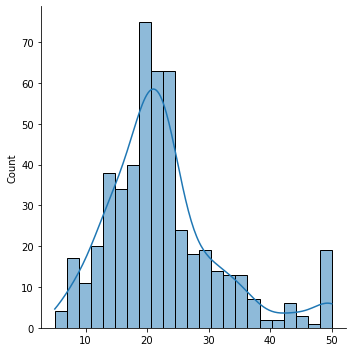

In [6]:
sns.displot(boston.target, kde=True)

Sprawdźmy też korelacje - zgodnie z założeniami regresji liniowej z wykładu silnie skorelowane cechy są bardzo niekorzystne dla tego algorytmu.

<AxesSubplot:>

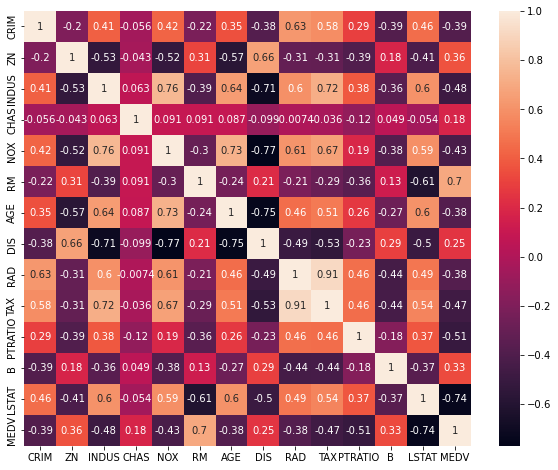

In [7]:
fig, ax = plt.subplots(figsize=(10., 8.))
sns.heatmap(ax=ax, data=boston_df.corr(), annot=True)

Na szczęście nie ma tu na ogół bardzo mocnych korelacji, poza zmiennymi RAD i TAX - są to odpowiednio dostęp do autostrad i podatek. Na pierwszy rzut oka nie widać, czemu korelacja tych cech miałaby być tak wysoka (może lokalizacje działek niedaleko wjazdów na autostrady są na ogół na cenniejszych gruntach z wyższym podatkiem?), ale tak się zdarza. Warto na to potem zwrócić uwagę.

## Part II - Zwykła regresja

Podzielmy teraz nasze dane na zbiory treningowy i testowy oraz je ustandaryzujmy.

In [8]:
X_train, X_test, y_train, y_test = train_test_split(boston.data, boston.target, test_size=0.3, random_state=0)

In [9]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train_rescaled = scaler.transform(X_train)
X_test_rescaled = scaler.transform(X_test)

Przypomnijmy sobie, że regresor `LinearRegression()` ze Scikit-learn'a ma 4 ważne hiperparametry:

1) `fit_intercept=True` - czy mamy wyraz wolny (bias, intercept), czy nie; jeżeli nasze dane są wycentrowane (mają wartość średnią 0), to powinniśmy dać False, żeby prosta przechodziła przez środek naszej chmury punktów

2) `normalize=False` - (ignorowane, gdy `fit_intercept=False`) gdy ma wartość `True`, to dokonamy normalizacji (odjęcia wartości średniej, znormalizowania wektorów kolumnowych cech dzieląc je przez ich długość) - tego rodzaju, o którym mówiliśmy na ostatnim wykładzie

3) `copy_X=True` - czy kopiować macierz `X`; jest to koszt pamięciowy, ale dla `False` macierz może zostać nadpisana dla wydajności (np. przy normalizacji), przez co stracimy oryginalne dane

4) `n_jobs=None` - ile rdzeni wykorzystać do obliczeń, regresja liniowa w wersjach różniczkowalnych (zwykła i L2) dobrze się uwspółbieżnia dzięki wykorzystaniu macierzy; typowo ustawiamy -1 (wszystkie rdzenie)

In [10]:
linear_model = LinearRegression(n_jobs=-1)
linear_model.fit(X_train_rescaled, y_train)

LinearRegression(n_jobs=-1)

Policzmy wartości metryk - 

In [11]:
def print_metrics(y_true, y_pred):
    rss = np.sum((y_true - y_pred) ** 2)
    ss = np.sum((y_true - y_true.mean()) ** 2)
    print(f"R^2: {1 - rss/ss}")
    print(f"RSS: {rss}")
    print(f"RMSE: {np.sqrt(np.mean((y_true - y_pred) ** 2))}")
    print(f"MAE: {np.mean(abs(y_true - y_pred))}")

y_pred = linear_model.predict(X_test_rescaled)

print_metrics(y_test, y_pred)

R^2: 0.6733825506400195
RSS: 4133.786796566248
RMSE: 5.214975145375403
MAE: 3.6099040603818127


Wypiszmy współczynniki dla poszczególnych cech, budując pomocniczy DataFrame:

In [12]:
print(f"Intercept: {linear_model.intercept_}")
coeff_names = boston_df.keys().drop(["MEDV"])  # remove target column from names - it does not have a coefficient

coeff_df = pd.DataFrame(linear_model.coef_, coeff_names, columns=["Coefficient"])
coeff_df

Intercept: 22.745480225988754


,Coefficient
CRIM,-1.011901
ZN,1.050280
INDUS,0.079210
CHAS,0.618962
NOX,-1.873691
RM,2.705270
AGE,-0.279573
DIS,-3.097665
RAD,2.096900
TAX,-1.886063


Współczynniki nie są zbyt duże - to znak, że jest całkiem nieźle. Warto jednak zwrócić uwagę, że np. waga cechy INDUS (ilość biznesów nie-usługowych, czyli industrialnych) jest bardzo mała - być może warto byłoby się jej pozbyć?

Kiedy wrócimy wyżej do macierzy z korelacjami i spojrzymy na korelację cechy INDUS z innymi, to ma dość mocne korelacje z cechami NOX (zanieczyszczenie powietrza) i AGE (liczba starych budynków). Skoro sama cecha INDUS jest mało warta, to być może te też? Sama cecha AGE też ma dość niewielką wagę, NOX już sporą, ale może to być mylny wynik, skoro mamy korelacje.

Przeanalizujmy teraz relację między wynikami naszego modelu a prawdziwymi wartościami. Z założeń regresji liniowej wiemy, że nie powinno być tu mocnych korelacji.

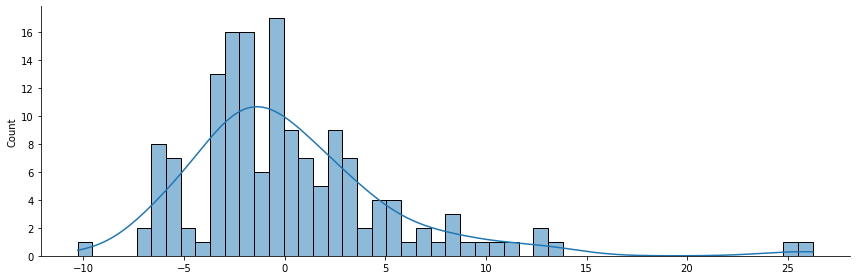

In [13]:
sns.displot(y_test - y_pred, bins=50, kde=True, aspect=3, height=4)

Jak widać, mamy rozkład w miarę zbliżony do normalnego, z mocnymi tendencjami do wartości średniej 0. To dobry znak - nasz regresor nieźle sobie radzi.

### Zadanie 1 - feature engineering

Dokonaj ręcznego feature engineeringu na podstawie dotychczasowych obserwacji. Usuń cechę INDUS i sprawdź, czy metryki są lepsze (na zbiorze testowym). Następnie usuń także cechę AGE, a potem też NOX - jak zmieniają się wyniki? Czy nasze podejrzenia okazały się słuszne?

Przydatna będzie metoda `.drop()` DataFrame'ów z Pandasa - [link do dokumentacji](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.drop.html).

## Part III - regresja wielomianowa

Użyjemy tutaj `PolynomialFeatures()`, aby wygenerować feature'y do stopnia 2 włącznie, co w połączeniu z `LinearRegression()` da regresję wielomianową.

Ważne argumenty `PolynomialFeatures()`:

1) `degree=2` - stopień wielomianu, który nas interesuje; wartość domyślna 2 daje sporo dodatkowych cech, ale jeszcze rozsądną liczbę

2) `interaction_only=False` - czy generować wszystkie cechy, czy tylko interakcje między zmiennymi (iloczyny kolumn)?

3) `include_bias=True` - czy dodawać explicite kolumnę samych 1, czyli bias? Jeżeli planujemy potem korzystać z modelu, który ma własny bias "wbudowany" (np. regresja liniowa), to trzeba ustawić False

In [14]:
poly_features = PolynomialFeatures(degree=2, include_bias=False)
X_train_poly = poly_features.fit_transform(X_train)
X_test_poly = poly_features.fit_transform(X_test)

scaler = StandardScaler()
scaler.fit(X_train_poly)
X_train_poly_rescaled = scaler.transform(X_train_poly)
X_test_poly_rescaled = scaler.transform(X_test_poly)

In [15]:
print(f"Previous number of features: {X_train_rescaled.shape[1]}")
print(f"Current number of features: {X_train_poly_rescaled.shape[1]}")

Previous number of features: 13
Current number of features: 104


In [16]:
polynomial_model = LinearRegression(n_jobs=-1)
polynomial_model.fit(X_train_poly_rescaled, y_train)

LinearRegression(n_jobs=-1)

In [17]:
y_pred = polynomial_model.predict(X_test_poly_rescaled)

print_metrics(y_test, y_pred)

R^2: 0.6486839499987673
RSS: 4446.381085158415
RMSE: 5.4085586933304235
MAE: 3.051967497292027


Według metryk RSS i RMSE radzimy sobie gorzej, według metryki MAE - lepiej. Może się zdarzyć, że będzie nam gorzej szło, bo znacznie zwiększyliśmy liczbę wymiarów i klątwa wymiarowości odciska tu swoje piętno. Fakt, że metryka MAE jest mniejsza, jest jednak bardzo ciekawy - potencjalnie mamy tu jakieś outliery, które dodatkowe feature'y mocniej uwydatniły, przez co RMSE wzrosło, a jednak bardziej "bezpośrednie" dopasowanie liczone wartością bezwzględną jest dokładniejsze.

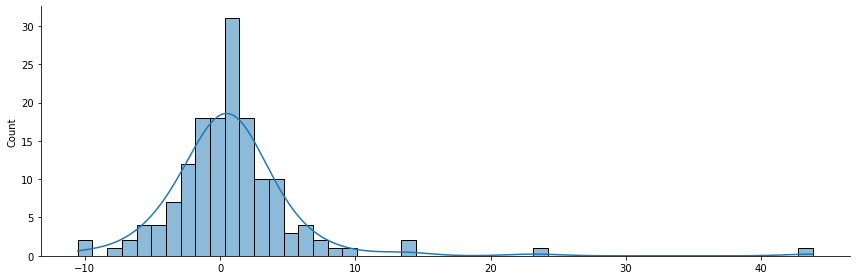

In [18]:
sns.displot(y_test - y_pred, bins=50, kde=True, aspect=3, height=4)

Porównajmy powyższy wykres z odpowiadającym mu wykresem dla zwykłej regresji. Możemy zauważyć, że wartości przewidziane przez regresję wielomianową na zbiorze testowym są dużo bardziej "zbite" wokół średniej wartości 0 i dużo mocniej przypominają rozkład normalny. Faktycznie jest to więc lepsze dopasowanie niż w przypadku zwykłej regresji.

### Zadanie 2 - overfit?

Ponad 100 feature'ów to bardzo dużo. Czy wystarczajco, żeby zapamiętać cały zbiór uczący? Sprawdź jak duże błędy popełnia model na zbiorze treningowym.

Jak widać ridge regression poradziło sobie o wiele lepiej. Wynika to z tego, że zmniejszyła wagę naszej jedynej cechy, czyli współczynnik kierunkowy tej prostej. Co jednak, gdy realnie chcielibyśmy wyższy współczynnik, a nie niższy?

### Part IV - regularyzacja L2 (rigde regression)

Teraz wykorzystamy regresor `Ridge` dla regularyzowanej regresji liniowej dla naszego zbioru danych.

Najważniejsze argumenty `Ridge`:

1) `alpha=1` - siła regularyzacji

2) `fit_intercept=True` - czy dodawać wyraz wolny (bias, intercept)? Dla danych wycentrowanych ustawiamy na `False`

3) `normalize=False` - czy normalizować dane? Normalizacja tutaj jest w takim sensie, jak na wykładzie, tj. usuwa wartość średnią z każdej kolumny i dzieli ją przez jej długość, normalizując ją do 1

4) `copy_X=True` - czy kopiować macierz X? Jeżeli jest `False`, to przekazana do treningu macierz `X` może zostać nadpisana dla wydajności

5) `max_iter=None`, `tol=1e-3` - parametry kontrolujące koniec iteracji dla solwerów iteracyjnych (zakładamy, że skończyliśmy optymalizować, gdy którykolwiek z warunków będzie osiągnięty); dla solwerów nie-iteracyjnych (np. "svd") znaczenie ma tylko `tol`, bo wyznacza precyzję rozwiązania

6) `solver="auto"` - rodzaj algorytmu (solwera) do użycia; jeżeli nie mamy jakichś wyraźnych potrzeb, to opcja `"auto"` sprawdza się bardzo dobrze, bo Scikit-learn sprawdza nasze dane i na ich podstawie stara się dobrać optymalny algorytm

7) `random_state=None` - jeżeli używamy solwera z elementami pseudolosowymi (SAG lub SAGA), to ustawiamy tu jakąś liczbę dla powtarzalności wyników

Zróbmy przykładowe ridge regression dla słabej regularyzacji i zobaczmy, jakie nam wyjdą metryki.

In [19]:
alpha = 10
ridge_model = Ridge(alpha=alpha)
ridge_model.fit(X_train_rescaled, y_train)

Ridge(alpha=10)

In [20]:
y_pred = ridge_model.predict(X_test_rescaled)

print_metrics(y_test, y_pred)

R^2: 0.667464867048182
RSS: 4208.683108279322
RMSE: 5.262005763939487
MAE: 3.608315093238688


Nie jest za dobrze - wyniki są lekko gorsze niż dla zwykłej regresji, a dużo gorsze niż dla wielomianowej. Może jednak nasza regularyzacja jest zbyt słaba? Sprawdźmy współczynniki dla poszczególnych cech.

In [21]:
print(f"Intercept: {ridge_model.intercept_}")
coeff_names = boston_df.keys().drop(["MEDV"])  # remove target column from names - it does not have a coefficient

coeff_df = pd.DataFrame(ridge_model.coef_, coeff_names, columns=["Coefficient"])
coeff_df

Intercept: 22.745480225988754


,Coefficient
CRIM,-0.933398
ZN,0.901779
INDUS,-0.130099
CHAS,0.653141
NOX,-1.554675
RM,2.780153
AGE,-0.318141
DIS,-2.751812
RAD,1.470846
TAX,-1.327215


Faktycznie wartości współczynników niewiele się zmieniły, więc nasza regularyzacja jest dość słaba. Może więc silniejsza regularyzacja bardziej pomoże?

### Zadanie 3 - wpływ regularyzacji L2 na wyniki

Stwórz wykres zależności wybranej metryki (np. RMSE lub MAE, bo są małe i czytelne) od współczynnika siły regularyzacji `alpha`. Metrykę mierzymy na zbiorze  Wypróbuj wartości od braku (`alpha=0`) do dość mocnej (`alpha=500`) z krokiem np. 5 (jeżeli moc obliczeniowa na to nie pozwoli, to np. krok 50). Wykonaj to na zbiorze testowym - dzięki temu faktycznie znajdziemy optymalną siłę regularyzacji dla tego zbioru. Czy nasze podejrzenie zbyt słabej regularyzacji okazało się słuszne?

## Part V - RFE

In [22]:
poly_features = PolynomialFeatures(degree=2, include_bias=False)
X_train_poly = poly_features.fit_transform(X_train)
X_test_poly = poly_features.fit_transform(X_test)

scaler = StandardScaler()
scaler.fit(X_train_poly)
X_train_poly_rescaled = scaler.transform(X_train_poly)
X_test_poly_rescaled = scaler.transform(X_test_poly)

In [23]:
model_rfe = RFE(LinearRegression(), n_features_to_select=1)
model_rfe.fit(X_train_poly_rescaled, y_train)
model_rfe.ranking_

array([ 98,   4,  16,   7,  95,   3,   1,  53, 100,  27,  76,   6,  57,
        83,  87,  45,  85,  96,  46,  64,  82,  54,  50,  47, 103,  74,
        71,  86,  99,  52,  48,  91, 102, 104,  49,  69,   5,  89,  29,
        97,  35,  26,  62,  67,  78,  14,  24,  17,  63,   8,  43,  40,
        72,  88,  44,  84,  39,  19,  73,  92,  51,  66,  34,  31,  80,
        36,  65,  55,  42,   2,  56,  61,  22,  10,  41,  77,  81,  93,
        15,  11,  68,  30,  20,  33,  79,  70,  38,  32,  58,  13,  12,
        60,  18,  23,  28,  25,  75,  90,  37,   9,  59, 101,  94,  21])

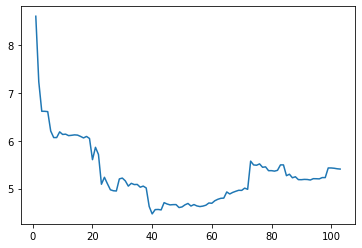

In [24]:
x = []
y = []

for n in range(1, X_train_poly_rescaled.shape[1]):
    feature_mask = model_rfe.ranking_ <= n
    
    model = LinearRegression()
    model.fit(X_train_poly_rescaled[:,feature_mask], y_train)
    
    y_pred = model.predict(X_test_poly_rescaled[:,feature_mask])
    rmse = np.sqrt(np.mean((y_test - y_pred) ** 2))
    x.append(n)
    y.append(rmse)
    
plt.plot(x, y)

### Zadanie 4

Wybierz optymalną ilość feature'ów jaką należy zostawić i spróbuj dodać regularyzację. Czy jesteś w stanie uzyskać wyniki lepsze niż dotychczas?

Udało ci się dotrzeć do samego końca! Teraz możemy w końcu połączyć wszystko, co sprawdziliśmy wyżej, w naprawdę solidny regresor dla problemu wyceny domów.

Postaraj się uzyskać optymalne metryki dla zbioru Boston Housing, korzystając z technik z tego notebooka:
- standaryzacja (`StandardScaler`) oraz normalizacja (`sklearn.preprocessing.normalize()`) cech
- stworzenie dodatkowych cech za pomocą `PolynomialFeatures`, być może samych interakcji
- wykorzystanie zarówno regularyzacji L2, jak i L1 dzięki `ElasticNet`
- optymalizacja hiperparametrów za pomocą `GridSearchCV` lub `RandomizedSearch`

Zbiór ten jest bardzo popularny i uzyskanie na nim dobrego wyniku za pomocą tych podstawowych technik świadczy o solidnej znajomości podstaw ML. W związku z tym w internecie można też znaleźć mnóstwo sztuczek, jak uzyskać lepsze wyniki, np. w ramach feature engineeringu zmienić rozkład jakiejś cechy jak w [tym przykładzie](https://scikit-learn.org/0.22/auto_examples/compose/plot_transformed_target.html), aby był bliższy rozkładowi normalnemu.

Powodzenia!